## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [ ]:
!pip install nlp

     |████████████████████████████████| 1.7MB 7.6MB/s 
     |████████████████████████████████| 245kB 45.9MB/s 


In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.5.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [ ]:
dataset = nlp.load_dataset("emotion")

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [ ]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [ ]:
tweets, labels = get_tweet(train)

In [ ]:
tweets[2], labels[2]

('im grabbing a minute to post i feel greedy wrong', 'anger')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words = 10000, oov_token = '<UNK>')
tokenizer.fit_on_texts(tweets)

In [ ]:
tokenizer.texts_to_sequences([tweets[1]])

[[2,
  40,
  101,
  60,
  8,
  15,
  494,
  5,
  15,
  3496,
  553,
  32,
  60,
  61,
  128,
  148,
  76,
  1480,
  4,
  22,
  1255]]

In [ ]:
tweets[1]

'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

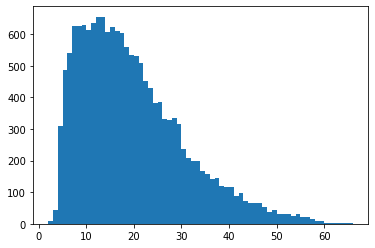

In [ ]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths,bins = len(set(lengths)))
plt.show()

In [ ]:
maxlen = 52

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post',padding='post',maxlen = maxlen)
  return padded

In [ ]:
padded_train_seq = get_sequences(tokenizer,tweets)

In [ ]:
padded_train_seq[1]

array([   2,   40,  101,   60,    8,   15,  494,    5,   15, 3496,  553,
         32,   60,   61,  128,  148,   76, 1480,    4,   22, 1255,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [ ]:
classes = set(labels)
print(classes)

{'love', 'sadness', 'joy', 'surprise', 'fear', 'anger'}


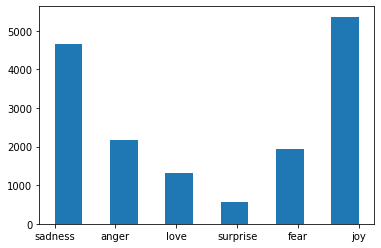

In [ ]:
plt.hist(labels,bins =11)
plt.show()

In [ ]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k,v in  class_to_index.items())

In [ ]:
class_to_index

{'anger': 5, 'fear': 4, 'joy': 2, 'love': 0, 'sadness': 1, 'surprise': 3}

In [ ]:
index_to_class

{0: 'love', 1: 'sadness', 2: 'joy', 3: 'surprise', 4: 'fear', 5: 'anger'}

In [ ]:
name_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [ ]:
train_labels = name_to_ids(labels)
print(train_labels[1])

1


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [ ]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(10000,16,input_length = maxlen),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
                                    tf.keras.layers.Dense(6,activation='softmax')


])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 52, 16)            160000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 52, 40)            5920      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [ ]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = name_to_ids(val_labels)

In [ ]:
val_tweets[1], val_labels[1]

('i feel like i am still looking at a blank canvas blank pieces of paper', 1)

In [ ]:
h = model.fit(
    padded_train_seq,train_labels,
    validation_data = (val_seq,val_labels),
    epochs =20,
    callbacks = [
                 tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 20s 18ms/step - loss: 1.3415 - accuracy: 0.4766 - val_loss: 0.9649 - val_accuracy: 0.6700
Epoch 2/20
500/500 [==============================] - 8s 16ms/step - loss: 0.6590 - accuracy: 0.7711 - val_loss: 0.5713 - val_accuracy: 0.8125
Epoch 3/20
500/500 [==============================] - 8s 16ms/step - loss: 0.3566 - accuracy: 0.8876 - val_loss: 0.4585 - val_accuracy: 0.8575
Epoch 4/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2297 - accuracy: 0.9324 - val_loss: 0.4376 - val_accuracy: 0.8705
Epoch 5/20
500/500 [==============================] - 8s 16ms/step - loss: 0.1607 - accuracy: 0.9512 - val_loss: 0.4755 - val_accuracy: 0.8710
Epoch 6/20
500/500 [==============================] - 8s 16ms/step - loss: 0.1236 - accuracy: 0.9622 - val_loss: 0.4462 - val_accuracy: 0.8700
Epoch 7/20
500/500 [==============================] - 8s 16ms/step - loss: 0.1011 - accuracy: 0.9681 - val_loss: 0.4243 - val_accuracy: 0.881

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

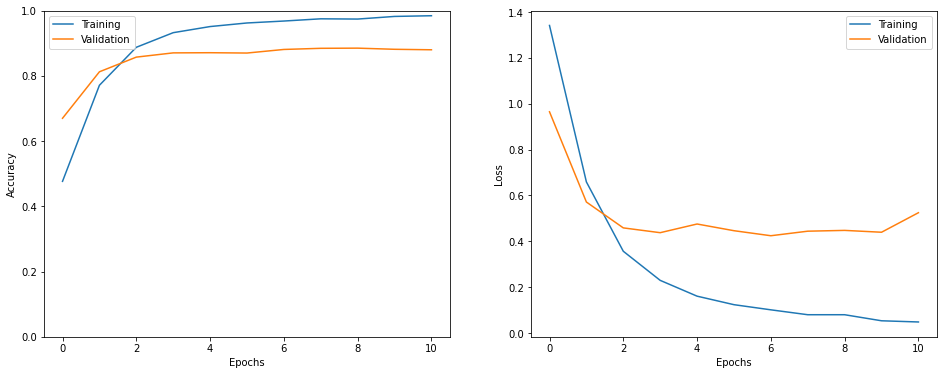

In [ ]:
show_history(h)

In [ ]:
test_tweets , test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = name_to_ids(test_labels)

In [ ]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.5096 - accuracy: 0.8625


In [ ]:
i = random.randint(0,len(test_labels)-1)

print("Sentence:", test_tweets[i] )
print("Emotion:", index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i],axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:' , pred_class)

Sentence: i was feeling overwhelmingly anxious so i went into my room to read my bible and pray
Emotion: fear
Predicted Emotion: fear


In [ ]:
preds = model.predict_classes(test_seq)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


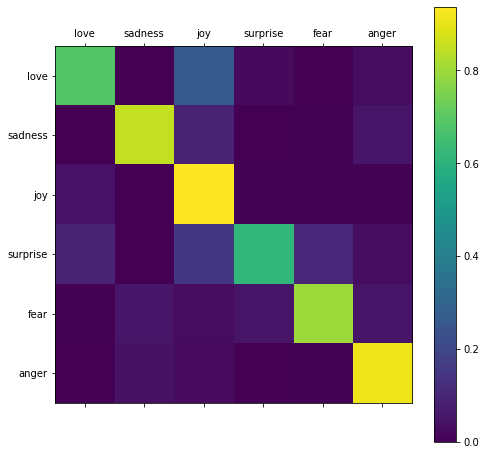

In [ ]:
show_confusion_matrix(test_labels,preds,list(classes))